In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

import seaborn as sns
sns.set_palette('viridis',4)
sns.set_style('white')

from ttvfaster import run_ttvfaster

import glob
import gzip
import pickle

from scipy import stats

I first define some logmass priors for the planet masses. I did a simple 3-part fit to the exoplanet archive, but you could also just use chen+kipping (which does a better job alleviating bias).


In [ ]:
def logmass_func(R):
    return 5.75402469 - (R<=12.2)*(R>=1.58)*(4.67363091 -0.38348534*R) - (R<1.58)*(5.81943841-3.81604756*np.log(R))
def logmass_sd_func(R):
    return (R<=8)*(0.07904372*R+0.24318296) + (R>8)*(0-0.02313261*R+1.06765343)

plt.plot(np.arange(0.9,20,0.01),np.exp(np.array([logmass_func(ir) for ir in np.arange(0.9,20,0.01)])))
plt.fill_between(np.arange(0.9,20,0.01),np.exp(np.array([logmass_func(ir)-logmass_sd_func(ir) for ir in np.arange(0.9,20,0.01)])),
                np.exp(np.array([logmass_func(ir)+logmass_sd_func(ir) for ir in np.arange(0.9,20,0.01)])),alpha=0.2)

plt.yscale('log')
plt.xscale('log')

tstart=1743.7192366566426-4
tend=2394.923144184979+4

Here I input the trace from my global model, which contains transit times, and then extract the transit times and "epochs" (i.e. number of transits since t0) into dicts:

In [18]:

filename='P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_add_parameter_groups_pmxsample_20211125'
save_loc="/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/"

bytes_in = bytearray(0)
max_bytes = 2**31 - 1
for file in glob.glob(save_loc+"TOI2076_finalmodel_"+filename+"_trace*gz"):
    with gzip.open(file, 'rb') as f_in:
        bytes_in += f_in.read(max_bytes)
trace = pickle.loads(bytes_in)

In [19]:
#trace=pickle.load(open("/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/TOI2076_finalmodel_P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_testing_entropy_correlations2_20211117_trace(logp=-2511.3).pkl","rb"))
ttimes={};epochs={}
for n in range(3):
    ttimes[n]=np.column_stack((np.average(trace['transit_times_'+str(n)],axis=0),np.std(trace['transit_times_'+str(n)],axis=0)))
    epochs[n]=np.column_stack((np.average(trace['t0'][:,n],axis=0),10*np.std(trace['t0'][:,n],axis=0)))
    if n==2: 
        ttimes[n]=np.vstack((ttimes[n][:2,:],ttimes[n][-1,:]))
        

Checking the masses of the planets (with extra 0.1 in logmp) are reasonable:

In [1]:
for n in range(3):
    logm=np.average(logmass_func(trace['r_pl'][:,n]))
    sd=np.average(logmass_sd_func(trace['r_pl'][:,n]))
    print(np.exp(logm),np.exp(logm+sd+0.1)-np.exp(logm),np.exp(logm)-np.exp(logm-sd-0.1))

NameError: name 'np' is not defined

Here we will star a "pars" dictionary which holds all the parameters we will sample in the TTV model, and their respective prior types

In [16]:
n_pls=3

#Extracting inclinations from trace:
incls=np.arctan(trace['a_Rs']/trace['b'])

#solar mass:
pars={'Ms':['norm',np.average(trace['Ms']),np.std(trace['Ms'])]}
#log planet mass / solar mass
#Period b
pars.update({'logMpbMs':['norm',
                          np.average(logmass_func(trace['r_pl'][:,0]))-np.log(pars['Ms'][1]*3.329e5),
                          np.average(logmass_sd_func(trace['r_pl'][:,0]))+pars['Ms'][2]/pars['Ms'][1]+0.1],
              'P_b':['truncnorm',np.average(trace['period'][:,0]),2.5*np.nanstd(trace['period'][:,0]),
                     np.average(trace['period'][:,0])-0.03,np.average(trace['period'][:,0])+0.03]})
pllist=np.array(['b','c','d'])[:n_pls]
#Looping through the planets and adding parameters:
for n,let in enumerate(pllist):
    ang_at_t0=360*(tstart-epochs[n][0][0])/np.average(trace['period'][:,n])
    if n>0:
        persd=np.sqrt(np.std(trace['period'][:,0])**2 + np.std(trace['period'][:,n])**2)
        persd=10*persd if n<2 else 2.5*persd
        logmratio_exp=np.average(logmass_func(trace['r_pl'][:,n]))-np.average(logmass_func(trace['r_pl'][:,0]))
        #For planets c,d,etc we'll reparameterise as:
        #  1) a log mass ratio wrt inner planet mass
        #  2) a period ratio wrt inner planet period
        pars.update({'logMp'+let+"/Mb":['truncnorm',logmratio_exp,np.average(logmass_sd_func(trace['r_pl'][:,1]))+0.1,
                                       logmratio_exp-3,logmratio_exp+3],
                     'P'+let+"/Pb":['truncnorm',np.average(trace['period'][:,n])/pars['P_b'][1],persd,
                                    np.average(trace['period'][:,n])/pars['P_b'][1]-0.03,
                                    np.average(trace['period'][:,n])/pars['P_b'][1]+0.03]})
    #Here we the eccentricity, omega, inclination, longitude of asecniding node and epoch
    #Eccentricity is just the half-normal distibution form vaneylen 2016 (for multiplanet systems)
    #The others are uniform angles
    pars.update({'ecc_'+let:['halfnorm',0.0,0.096],
                 'omega_'+let:['uniform',-np.pi,np.pi],
                 'incl_'+let:['norm',np.average(incls[:,n]),2.5*np.std(incls[:,n])],
                 'longnode_'+let:['uniform',-np.pi,np.pi],
                 'epoch'+let:['norm',epochs[n][0][0],0.05]})
    #longitude_of_asc_node + argument_of_periasteron/2 = time of transit
    #mean_anomaly ~ (t-t0)/per + argument_of_periasteron/2
    #mean_anomaly = longnode + pi/2 + angle_at_tstart_
    #(epochs[n][0][0]-tstart)/x[2+n*7]th
#pars.update({'logjitter':['halfnorm',np.log(0.1*np.average(np.hstack([ttimes[n][:,1] for n in ttimes]))),1]})
        
def prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u
    for n,p in enumerate(pars):
        if pars[p][0]=='uniform':
            x[n]=pars[p][1] + (pars[p][2]-pars[p][1]) * u[n]
        elif pars[p][0]=='norm':
            x[n]=scipy.stats.norm.ppf(u[n],pars[p][1],pars[p][2])
        elif pars[p][0]=='halfnorm':
            x[n]=scipy.stats.halfnorm.ppf(u[n],pars[p][1],pars[p][2])
        elif pars[p][0]=='truncnorm':
            a=pars[p][3];b=pars[p][4]
            ar, br = (a - pars[p][1]) / pars[p][2], (b - pars[p][1]) / pars[p][2]
            x[n]=scipy.stats.truncnorm.ppf(u[n], ar, br, loc=pars[p][1], scale=pars[p][2])
        elif pars[p][0]=='rayleigh':
            x[n]=scipy.stats.rayleigh.ppf(u[n],pars[p][1])
        elif pars[p][0]=='beta':
            x[n]=scipy.stats.beta.ppf(u[n],pars[p][1],pars[p][2])
    return x

def loglike(x):
    """The log-likelihood function."""
    n_pls=3
    params=[x[0]] #stellar mass
    for n in range(n_pls):
        #transit when mean_anomaly=pi/2. mean_anomaly = 
        if n==0:
            params+=[np.exp(x[1])]                      #mass
            p=x[2]                                      #period days
        else:
            params+=[np.exp(x[1+n*7] + x[1])]           #Mc/Ms = exp(log(Mc/Mb) - log(Mb/Ms))
            p=x[2]*x[2+n*7]                             #Pc = Pb * Pc/Pb
        params+=[p]
        params+=[x[3+n*7]*np.cos(x[4+n*7])]             #ecos(arg peri)
        params+=[x[5+n*7]]                              #inclination
        params+=[x[6+n*7]]                              #Omega / longitude of ascending node
        params+=[x[3+n*7]*np.sin(x[4+n*7])]             #esin(arg peri)
        #newt0=tstart-np.max(np.arange(tstart-x[7+n*7],0,p)) #Getting the first transit time after tstart
        params+=[x[7+n*7]-tstart]                       #Transit Time 1 - readjusted to the start time
    
    #Doing the TTV faster model:
    results = run_ttvfaster(n_pls, params, tstart, tend, 6)
    llk=0
    
    #Looping through each planet and adding a loglik for the (predicted - observed) distances:
    for n in range(n_pls):
        model_times = results[n][np.argmin((ttimes[n][:,0][:,None]-results[n][None,:])**2,axis=1)]
        sigma2 = ttimes[n][:,1]**2
        #print(i,np.sum(idx_planet1),np.sum(np.array(results['positions'][2])==-2),times,ttimes[n][:,0],sigma2)
        llk += -0.5 * np.sum((ttimes[n][:,0] - model_times) ** 2 / sigma2 + np.log(sigma2))
    #Adding prior on eccentricity 
    
    return llk


In [2]:
import scipy.interpolate as interp
def plot_params(x,savename=None,before=300,after=500,
                tstart=1739.7192366566426,tend=2398.923144184979,plot_2sigma=False):
    finetime=np.arange(tstart-before,tend+after,0.1)
    x=np.array(x)
    if len(np.shape(x))==1:
        x=np.array([x])
    params=np.column_stack((x[:,0],np.exp(x[:,1]),x[:,2]))
    for n in range(n_pls):
        if n>0:
            params=np.column_stack((params,np.exp(x[:,1+n*7] + x[:,1]),x[:,2]*x[:,2+n*7]))
        t0s=(x[:,7+n*7]-(tstart-before))-params[:,2+n*7]*np.floor(((x[:,7+n*7]-(tstart-before))/params[:,2+n*7]))
        params=np.column_stack((params,x[:,3+n*7]*np.cos(x[:,4+n*7]),
                                x[:,5+n*7],x[:,6+n*7],x[:,3+n*7]*np.sin(x[:,4+n*7]),t0s))
        
    '''for i in range(x.shape[0]):
        params=[x[i][0]] #stellar mass
        ps={}
        for n in range(n_pls):
            #transit when mean_anomaly=pi/2. mean_anomaly = 
            if n==0:
                params+=[np.exp(x[i][1])]                      #mass
                ps[n]=x[i][2]                                      #period days
            else:
                params+=[np.exp(x[1+n*7] + x[i][1])]           #Mc/Ms = exp(log(Mc/Mb) - log(Mb/Ms))
                ps[n]=x[i][2]*x[i][2+n*7]                             #Pc = Pb * Pc/Pb
            params+=[ps[n]]
            params+=[x[i][3+n*7]*np.cos(x[i][4+n*7])]             #ecos(arg peri)
            params+=[x[i][5+n*7]]                              #inclination
            params+=[x[i][6+n*7]]                              #Omega / longitude of ascending node
            params+=[x[i][3+n*7]*np.sin(x[i][4+n*7])]             #esin(arg peri)
            print((x[i][7+n*7]-tstart),(x[i][7+n*7]-tstart)+before,((x[i][7+n*7]-tstart)+before)/ps[n],np.floor(((x[i][7+n*7]-tstart)+before)/ps[n]))
            newt0=(x[i][7+n*7]-tstart)-ps[n]*np.floor(((x[i][7+n*7]-tstart)+before)/ps[n]) #Getting the first transit time after tstart
            print((x[i][7+n*7]-tstart)-ps[n]*np.floor(((x[i][7+n*7]-tstart)+before)/ps[n]),-np.max(np.arange((tstart-before)-x[i][7+n*7],0,ps[n])))
            params+=[newt0]                                 #Transit Time 1
            print(x[i][7+n*7]-(tstart-before),newt0)'''
    models={n:[] for n in range(n_pls)}
    for i in range(params.shape[0]):
        results = run_ttvfaster(n_pls, params[i], tstart-before, tend+after, 6)
        
        for n in range(n_pls):
            model_trans_ix=np.round((results[n]-x[i,7+n*7])/params[i,2+n*7])
            #print(x[i,7+n*7],params[i,2+n*7],
            #      x[i,7+n*7]+params[i,2+n*7]*np.min(model_trans_ix),
            #      x[i,7+n*7]+params[i,2+n*7]*np.max(model_trans_ix))
            models[n]+=[interp.interp1d(x[i,7+n*7]+model_trans_ix*params[i,2+n*7], results[n]-(x[i,7+n*7]+model_trans_ix*params[i,2+n*7]),kind='linear', fill_value='extrapolate')(finetime)]

    if x.shape[0]==1:
        models={n:np.array(models[n]) for n in models}
    else:
        if plot_2sigma:
            models={n:np.nanpercentile(np.vstack(models[n]),[2.28,15.87,50,84.13,97.72],axis=0) for n in models}
        else:
            models={n:np.nanpercentile(np.vstack(models[n]),[15.87,50,84.13],axis=0) for n in models}

    #print([models[n].shape for n in models],finetime.shape)
    for n in range(n_pls):
        p = np.nanmedian(x[:,2]) if n==0 else np.nanmedian(x[:,2]*x[:,2+n*7])
        t0 = np.nanmedian(x[:,7+n*7])
        real_trans_ix=np.round((ttimes[n][:,0]-t0)/p)
        if x.shape[0]>1:
            if plot_2sigma:
                plt.fill_between(finetime,
                                 1440*models[n][0],1440*models[n][4],color='C'+str(n),alpha=0.25)
                plt.fill_between(finetime,
                                1440*models[n][1],1440*models[n][3],color='C'+str(n),alpha=0.25)
                plt.plot(finetime, 1440*models[n][2],'-',color='C'+str(n),alpha=0.5)
            else:
                plt.fill_between(finetime,
                                1440*models[n][0],1440*models[n][2],color='C'+str(n),alpha=0.25)
                plt.plot(finetime, 1440*models[n][1],'-',color='C'+str(n),alpha=0.5)
        else:
            plt.plot(finetime, 1440*models[n][0],'-',color='C'+str(n),alpha=0.5)
        plt.errorbar(t0+real_trans_ix*p,
                     1440*(ttimes[n][:,0]-real_trans_ix*p-t0),
                     yerr=1440*ttimes[n][:,1],fmt='o',markeredgecolor='w',alpha=0.8,label='bcd'[n])
        if n==2:
            dtrans1=np.argmin(abs(finetime-np.nanmedian(trace['transit_times_'+str(2)][:,-2])))
            dtrans2=np.argmin(abs(finetime-np.nanmedian(trace['transit_times_'+str(2)][:,-1])))
            if plot_2sigma and x.shape[0]>1:
                plt.plot([finetime[dtrans1],finetime[dtrans2]],
                         [1440*models[n][2,dtrans1],1440*models[n][2,dtrans2]],
                         '^',c='C'+str(n),markeredgecolor='w')#,label='predicted')
            elif x.shape[0]>1:
                plt.plot([finetime[dtrans1],finetime[dtrans2]],[1440*models[n][1,dtrans1],1440*models[n][1,dtrans2]],
                         '^',c='C'+str(n),markeredgecolor='w')#,label='predicted')
            else:
                plt.plot([finetime[dtrans1],finetime[dtrans2]],[1440*models[n][0,dtrans1],1440*models[n][0,dtrans2]],
                         '^',c='C'+str(n),markeredgecolor='w')#,label='predicted')

            extra_trans_ix=t0+p*np.round((np.nanmedian(trace['transit_times_'+str(2)][:,2],axis=0)-t0)/p)
            plt.errorbar(extra_trans_ix,
                         1440*(np.nanmedian(trace['transit_times_'+str(2)][:,2],axis=0)-extra_trans_ix),
                         yerr=1440*np.nanstd(trace['transit_times_'+str(2)][:,2],axis=0),
                         fmt='v',c='C'+str(n),markeredgecolor='k')#,label='observed')

    maxmax=1440*np.max([np.max(models[n]) for n in models])+5
    minmin=1440*np.min([np.min(models[n]) for n in models])-5
    plt.fill_between([2664.75,2678.25],[minmin,minmin],[maxmax,maxmax], color='C3',alpha=0.25)#,label="TESS 2022")
    plt.fill_between([2678.75,2690.75],[minmin,minmin],[maxmax,maxmax], color='C3',alpha=0.25)
        
    plt.legend(loc=4)
    plt.ylim(minmin,maxmax)
    plt.xlim(finetime[0],finetime[-1])
    plt.xlabel("Time [BJD-247000]")
    plt.ylabel("(O-C) [mins]")
    if savename is not None:
        plt.savefig(savename)


-5576968.487785649


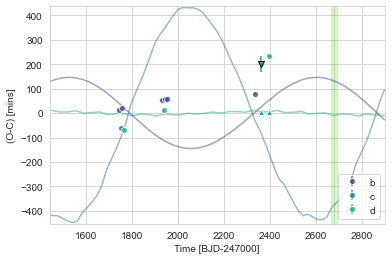

In [21]:
x=[]
for p in pars:
    if 'norm' in pars[p][0]:
        x+=[np.random.normal(pars[p][1],0.66*pars[p][2])]
    else:
        x+=[np.random.normal(0.5*(pars[p][1]+pars[p][2]),0.05*(pars[p][2]-pars[p][1]))]
        n_pls=3
print(loglike(x))
plot_params(x)

In [1]:
#If we have data to reload:
import json
data = json.load(open("/Volumes/LUVOIR/Cheops_data/TOI2076/UltranestOutputs/reparameterised_eccomega_2dtrans_ultranest_analysis_3pl/info/results.json","r"))
                 

In [9]:
import h5py
filename = "/Volumes/LUVOIR/Cheops_data/TOI2076/UltranestOutputs/reparameterised_eccomega_2dtrans_ultranest_analysis_3pl/results/points.hdf5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['points']>


## Running UltraNext:

In [27]:
filename="4dtrans_ultranest_analysis_goodinputs_nojitter2"


Initial exploration with a ReactiveNestedSampler:

In [22]:
import ultranest
fixsampler = ultranest.ReactiveNestedSampler(list(pars.keys()), loglike, prior_transform,
                                             log_dir="/Volumes/LUVOIR/Cheops_data/TOI2076/UltranestOutputs/"+filename,
                                             resume=True)
result = fixsampler.run(max_ncalls=25000)
fixsampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  1367.16 [-13623.5785..-9994.5072] | it/evals=2955/24983 eff=12.0205% N=400  0  0   
[ultranest] Likelihood function evaluations: 25005
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Reached maximum number of likelihood calls (25005 > 25000)...
[ultranest] done iterating.

logZ = -1380.550 +- 0.966
  single instance: logZ = -1380.550 +- 0.180
  bootstrapped   : logZ = -1544.041 +- 0.673
  tail           : logZ = +- 0.693
insert order U test : converged: True correlation: inf iterations

    Ms                  : 0.693 │                    ▇                  │1.036     0.872 +- 0.000
    logMpbMs            : -11.637│                   ▇                   │-10.537    -11.087 +- 0.000
    P_b                 : 10.3488168401089897│                      ▇                │10.3612452925688050    10.3561166583931730 +- 0.0000000000000036
    ecc_b               : 0.0000001203181571724

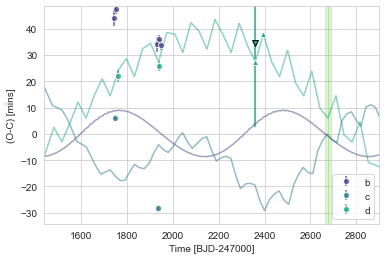

In [23]:
plot_params(result['posterior']['mean'])

#### Is this is slow (it will be), a stepsampler is apparently better:

In [24]:
import ultranest.stepsampler

# have to choose the number of steps the slice sampler should take
# after first results, this should be increased and checked for consistency.

# create step sampler:
#fixstepsampler = ultranest.ReactiveNestedSampler(list(pars.keys()), loglike, prior_transform,
#                                                log_dir="fixed_ultranest_analysis", resume=True)
fixsampler.stepsampler = ultranest.stepsampler.RegionSliceSampler(nsteps=(1+(n_pls*7))*2)

# alternatively, we can let the sample identify the number of steps needed on the fly:
# This is done by requiring the point to move at least the typical distance
# between live points, on average.
#sampler2.stepsampler = ultranest.stepsampler.RegionSliceSampler(nsteps=400, adaptive_nsteps='move-distance')

# run again:
stepresult = fixsampler.run(max_ncalls=30000000,dlogz=0.25)
#fixsampler.print_results()

[ultranest] Widening roots to 400 live points (have 400 already) ...


[ultranest] Explored until L=8e+01  76.8184..76.8187]*| it/evals=16884/2461555 eff=0.5715% N=400             0  
[ultranest] Likelihood function evaluations: 2461555
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 39.49 +- 0.1881
[ultranest] Effective samples strategy satisfied (ESS = 3100.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 526 minimum live points (dlogz from 0.16 to 0.45, need <0.25)
[ultranest]   logZ error budget: single: 0.29 bs:0.19 tail:0.01 total:0.19 required:<0.25
[ultranest] Widening roots to 526 live points (have 400 already) ...
[ultranest] Sampling 126 live points from prior ...
[ultranest] Explored until L=8e+01  76.8342..76.8343]*| it/evals=22298/3309070 eff=0.6388% N=526                6     
[ultranest] Likelihood function evaluations: 3309070
[ultranest] Writing samples

#### Plotting the results:

In [38]:
from ultranest.plot import cornerplot
cornerplot(stepresult)
#fig.savefig("larger_sds_ultranest_analysis_3pl_corner.png",dpi=400)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f933fa68af0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'P_b'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/private/var/folders/p0/tmr0j01x4jb3qrbc5b0gnxcw0000gn/T/matplotlib-ljuueklu/t
ex.cache/95125653b1f187acbd4bc3c42eee9ad6.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2020/texmf-dist/tex/latex/lm/lmodern.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 95125653b1f187acbd4bc3c42eee9ad6.aux.
(/usr/local/texlive/2020/texmf-dist/tex/latex/lm/ot1lmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily P_
                  b}
No pages of output.
Transcript written on 95125653b1f187acbd4bc3c42eee9ad6.log.




RuntimeError: latex was not able to process the following string:
b'P_b'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/private/var/folders/p0/tmr0j01x4jb3qrbc5b0gnxcw0000gn/T/matplotlib-ljuueklu/t
ex.cache/95125653b1f187acbd4bc3c42eee9ad6.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2020/texmf-dist/tex/latex/lm/lmodern.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 95125653b1f187acbd4bc3c42eee9ad6.aux.
(/usr/local/texlive/2020/texmf-dist/tex/latex/lm/ot1lmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily P_
                  b}
No pages of output.
Transcript written on 95125653b1f187acbd4bc3c42eee9ad6.log.




<Figure size 3571.2x3571.2 with 529 Axes>

In [5]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=14)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 


<ipython-input-5-3f7f21969d29>:7: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


(0.0, 40.0)

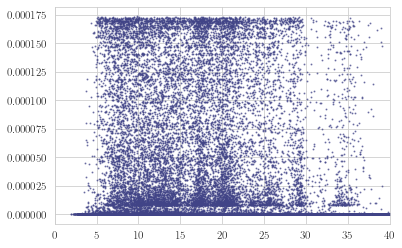

In [64]:
_=plt.scatter(3.329e5*np.exp(stepresult['weighted_samples']['points'][:,1]+stepresult['weighted_samples']['points'][:,0]),
              stepresult['weighted_samples']['weights'],s=1,alpha=0.6)
#plt.ylim(-5,80)
plt.xlim(0,40)


(array([   33.,   296.,  1970.,  7365., 12096., 12597.,  8382.,  2181.,
          420.,    32.]),
 array([0.72228229, 0.7513011 , 0.7803199 , 0.80933871, 0.83835751,
        0.86737632, 0.89639512, 0.92541393, 0.95443273, 0.98345154,
        1.01247034]),
 <BarContainer object of 10 artists>)

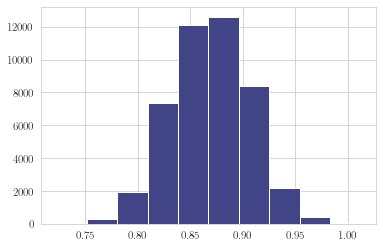

In [65]:
_=plt.hist(stepresult['weighted_samples']['points'][:,0])

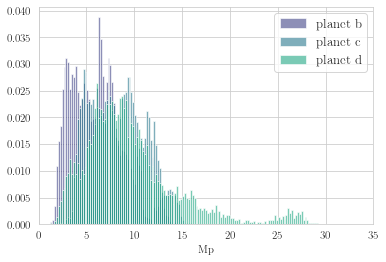

In [66]:
_=plt.hist(3.329e5*np.exp(stepresult['weighted_samples']['points'][:,1])*stepresult['weighted_samples']['points'][:,0],
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,35,0.2),
           alpha=0.6,label='planet b')
_=plt.hist(3.329e5*np.exp(stepresult['weighted_samples']['points'][:,8]+stepresult['weighted_samples']['points'][:,1])+stepresult['weighted_samples']['points'][:,0],
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,35,0.2),
           alpha=0.6,label='planet c')
_=plt.hist(3.329e5*np.exp(stepresult['weighted_samples']['points'][:,15]+stepresult['weighted_samples']['points'][:,1])+stepresult['weighted_samples']['points'][:,0],
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,35,0.2),
           alpha=0.6,label='planet d')
plt.legend()
plt.xlim(0,35)
plt.xlabel('Mp')
plt.savefig(filename+"_masspdfs.png")

In [10]:
stepresult['weighted_samples'].keys()

NameError: name 'stepresult' is not defined

In [47]:
newdata=np.column_stack((stepresult['weighted_samples']['weights'],stepresult['weighted_samples']['logl'],stepresult['weighted_samples']['points']))

1088928

In [11]:
data=np.genfromtxt("/Volumes/LUVOIR/Cheops_data/TOI2076/UltranestOutputs/"+"P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_add_parameter_groups_pmxsample_20211125"+"/chains/weighted_post.txt")[1:]

In [12]:
ix=data[:,0]>1e-4

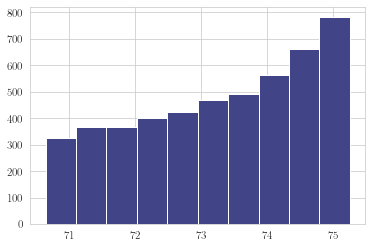

In [35]:
_=plt.hist(data[data[:,0]>1e-4,1])

The model might be domincated by low-probability models, so we can clip at e.g. 1e-4:

In [8]:
data

{'niter': 76424,
 'logz': -97.45273609352563,
 'logzerr': 0.2944073032722469,
 'logz_bs': -97.51165134004947,
 'logz_single': -97.45273609352563,
 'logzerr_tail': 0.009950639300527087,
 'logzerr_bs': 0.2942390949509388,
 'ess': 10617.840255981428,
 'H': 51.093145379184875,
 'Herr': 0.18304748370330282,
 'posterior': {'mean': [0.8887311786843985,
   -11.213100226189265,
   10.35484451946323,
   0.08131968657391489,
   0.42462366066418994,
   1.5613331802180794,
   -2.1393522640515,
   1743.7346384736888,
   -0.12257453081406475,
   2.0296349473776365,
   0.07848671554858674,
   2.361929835298219,
   1.5687948456533587,
   2.2271444818988058,
   1748.6770818167631,
   -0.6793589846420062,
   3.3922000443807696,
   0.11912237547398877,
   -1.3259609063475044,
   1.5520864589050345,
   -2.317672207771938,
   1762.6488752254004],
  'stdev': [0.005235437043585316,
   0.12940137228704307,
   1.0926631900123019e-05,
   0.005321499337989491,
   0.43455850755362346,
   0.0003221611633751327,
   

In [13]:
clippeddata=data[data[:,0]>1e-4]
print(clippeddata.shape,data.shape)

(4848, 24) (45372, 24)


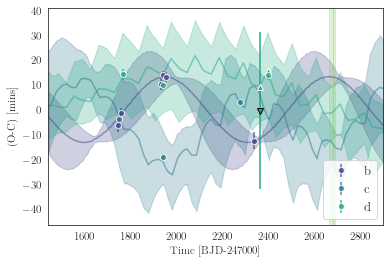

In [20]:
n_pls=3
plot_params(clippeddata[:,2:],
            plot_2sigma=False,savename=filename+'_allmodels_ref.pdf')

9201 (14593,)
9201 2359.819236655806
[17.00018959 18.00033162]


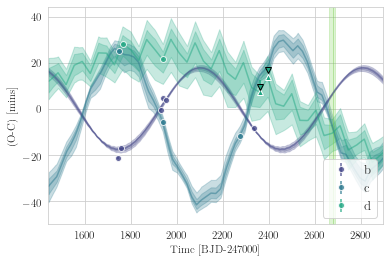

In [123]:
plot_params(data[data[:,0]>1e-4,2:],
            plot_2sigma=True,savename=filename+'_allmodels_w2sigma.pdf')

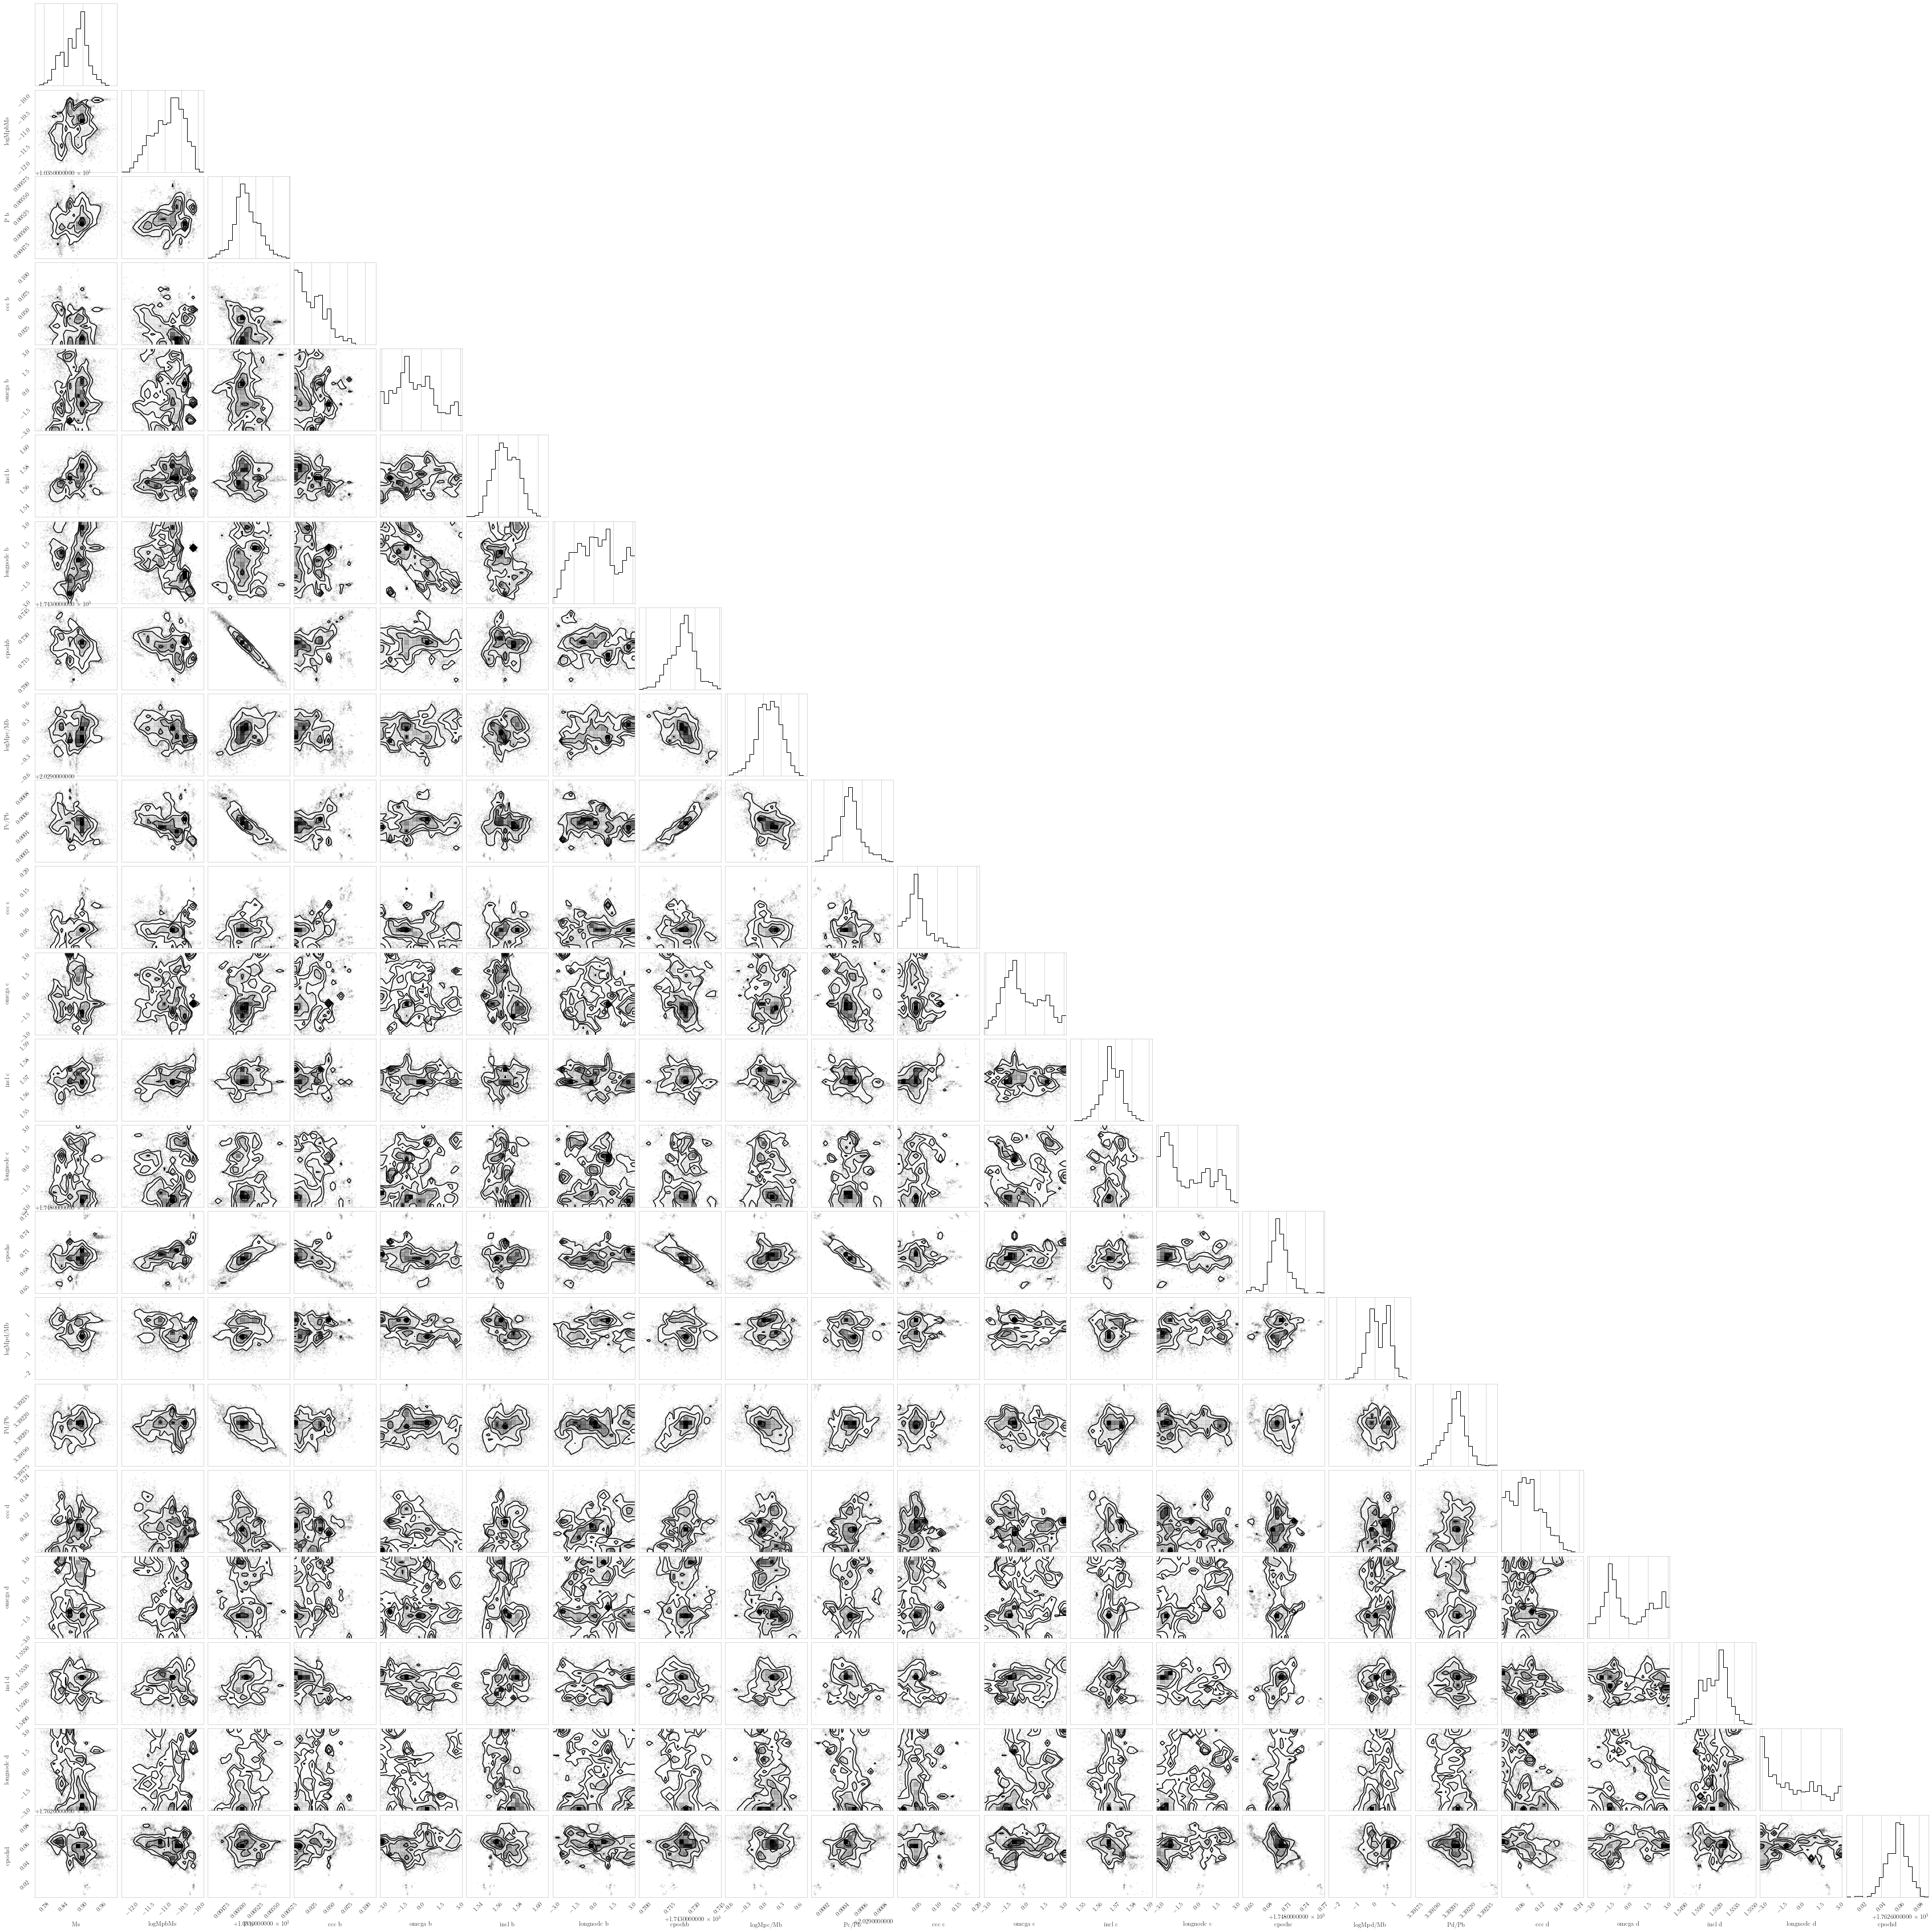

In [38]:
from corner import corner
fig=corner(data[data[:,0]>1e-5,2:],weights=data[data[:,0]>1e-5,0],labels=[p.replace('_',' ').replace('/','$/$') for p in pars],rasterized=True)
fig.savefig(filename+"_all_params_corner.png",dpi=500)


In [48]:
import pandas as pd
ix=data[:,0]>1e-8
drvdat= pd.DataFrame({'Mass, $M_p$ [$M_\oplus$]':np.hstack((3.329e5*np.exp(data[ix,3])*data[ix,2],
                                        3.329e5*np.exp(data[ix,3])*data[ix,2]*np.exp(data[ix,10]),
                                        3.329e5*np.exp(data[ix,3])*data[ix,2]*np.exp(data[ix,17]))),
                      'Eccentricity, $e$':np.hstack((data[ix,5],data[ix,12],data[ix,19])),
                      'planet':np.hstack((np.tile('b',np.sum(ix)),np.tile('c',np.sum(ix)),np.tile('d',np.sum(ix)))),
                      'weight':np.hstack((data[ix,0],data[ix,0],data[ix,0]))})

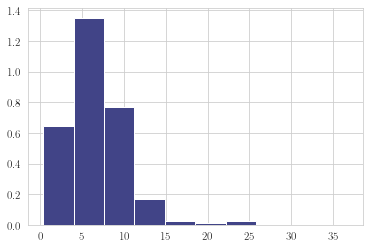

In [50]:
_=plt.hist(drvdat['Mass, $M_p$ [$M_\oplus$]'],weights=drvdat['weight'])

/Users/hosborn/miniconda3/envs/newxo/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'weight'
  cset = contour_func(


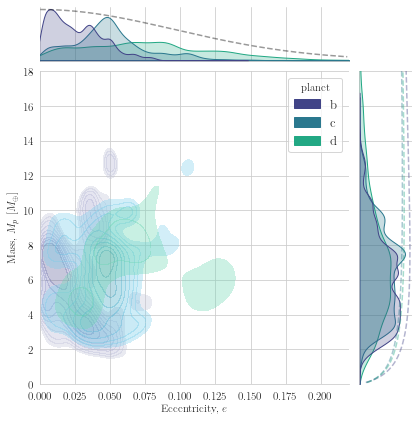

In [72]:
ax=sns.jointplot(data=drvdat, x="Eccentricity, $e$", y="Mass, $M_p$ [$M_\oplus$]", 
                 weight="weight", hue="planet", kind="kde",alpha=0.35,thresh=.25)
epriors=scipy.stats.halfnorm.pdf(np.arange(0.0,0.22,0.001),0,0.096)
ax.fig.axes[1].plot(np.arange(0.0,0.22,0.001),epriors,"--k",alpha=0.4)
for n in range(3):
    logmass=np.average(logmass_func(trace['r_pl'][:,n]))
    logstd=np.average(logmass_func(trace['r_pl'][:,n]))+0.1
    logmrange=np.arange(np.log(0.1),np.log(35),0.02)
    mpriors=scipy.stats.norm.pdf(logmrange,logmass,logstd)
    #print(np.exp(logmrange),mpriors)
    ax.fig.axes[2].plot(0.32*mpriors,np.exp(logmrange),"--",color='C'+str(n),alpha=0.4)
ax.fig.axes[2].set_ylim(0.,18)
ax.fig.axes[0].set_xlim(0.,0.22)
ax.fig.savefig(filename+"mass_ecc_kdes_wpriors.pdf")


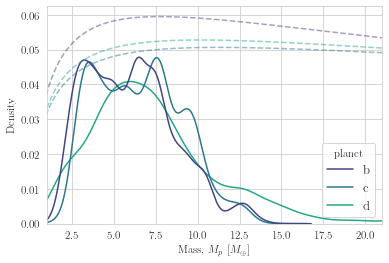

In [86]:
ax=sns.kdeplot(data=drvdat, x="Mass, $M_p$ [$M_\oplus$]", 
                 weights="weight", hue="planet")
for n in range(3):
    logmass=np.average(logmass_func(trace['r_pl'][:,n]))
    logstd=np.average(logmass_func(trace['r_pl'][:,n]))+0.1
    logmrange=np.arange(np.log(0.1),np.log(35),0.02)
    mpriors=scipy.stats.norm.pdf(logmrange,logmass,logstd)
    #print(np.exp(logmrange),mpriors)
    ax.plot(np.exp(logmrange),0.32*mpriors,"--",color='C'+str(n),alpha=0.5)
#plt.plot([-1,-1],[0.01,0.05],'--k',label='priors')
#plt.legend()
plt.xlim(1,21)
plt.savefig(filename+"mass_kdes_wpriors.pdf")

In [87]:
filename

'4dtrans_ultranest_analysis_goodinputs_nojitter2'

/Users/hosborn/miniconda3/envs/newxo/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'weight'
  cset = contour_func(


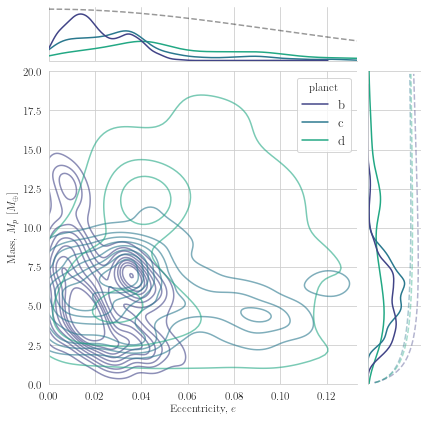

In [85]:
ax=sns.jointplot(data=drvdat, x="Eccentricity, $e$", y="Mass, $M_p$ [$M_\oplus$]", weight="weight", hue="planet", kind="kde",alpha=0.6)
epriors=scipy.stats.halfnorm.pdf(np.arange(0.0,0.2,0.001),0,0.096)
ax.fig.axes[1].plot(np.arange(0.0,0.2,0.001),1.5*epriors,"--k",alpha=0.4)
for n in range(3):
    logmass=np.average(logmass_func(trace['r_pl'][:,n]))
    logstd=np.average(logmass_func(trace['r_pl'][:,n]))+0.1
    logmrange=np.arange(np.log(0.1),np.log(20),0.01)
    mpriors=scipy.stats.norm.pdf(logmrange,logmass,logstd)
    #print(np.exp(logmrange),mpriors)
    ax.fig.axes[2].plot(0.5*mpriors,np.exp(logmrange),"--",color='C'+str(n),alpha=0.4)
ax.fig.axes[2].set_ylim(0.,20)
ax.fig.axes[0].set_xlim(0.,0.133)
ax.fig.savefig(filename+"mass_ecc_kdes_wpriors.pdf")


(0.0, 20.0)

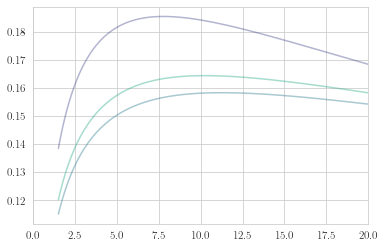

In [78]:
for n in range(3):
    logmass=np.average(logmass_func(trace['r_pl'][:,n]))
    logstd=np.average(logmass_func(trace['r_pl'][:,n]))+0.1
    logmrange=np.arange(np.log(1.5),np.log(50),0.01)
    mpriors=scipy.stats.norm.pdf(logmrange,logmass,logstd)
    #print(np.exp(logmrange),mpriors)
    plt.plot(np.exp(logmrange),mpriors,"-",alpha=0.4)
plt.xlim(0,20)

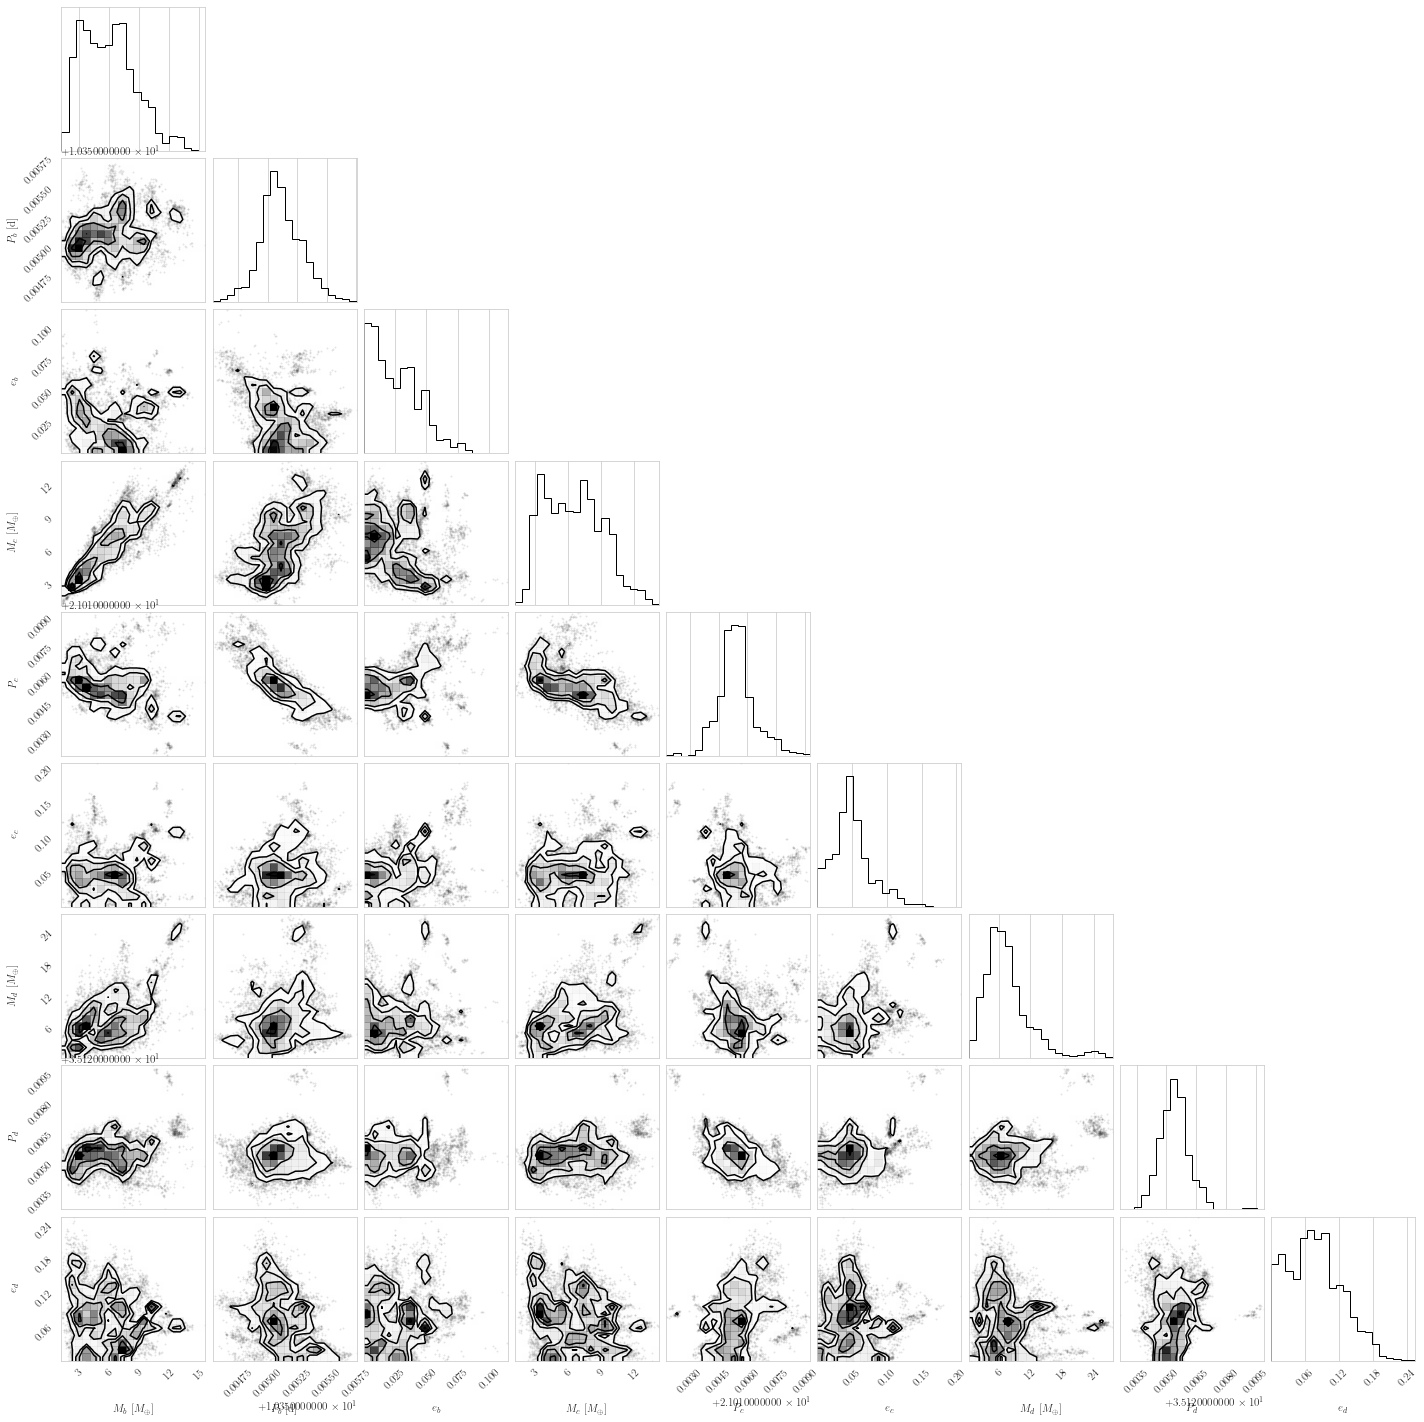

In [52]:
ix=data[:,0]>1e-5
moddat=np.column_stack((3.329e5*np.exp(data[ix,3])*data[ix,2],data[ix,4],data[ix,5]))
moddat=np.column_stack((moddat,np.exp(data[ix,10])*moddat[:,0],data[ix,11]*moddat[:,1],data[ix,12],
                               np.exp(data[ix,17])*moddat[:,0],data[ix,18]*moddat[:,1],data[ix,19]))
modlabs=['$M_b$ [$M_\oplus$]','$P_{b}$ [d]','$e_{b}$','$M_c$ [$M_\oplus$]','$P_c$','$e_c$','$M_d$ [$M_\oplus$]','$P_d$','$e_d$']
fig=corner(moddat,weights=data[ix,0],labels=modlabs,rasterized=True)
fig.savefig(filename+"derived_params_corner.png",dpi=500)


In [120]:
#2664.75,2678.25,2678.75,2690.75
                     
n=26
np.nanmedian(data[ix,23]+n*moddat[:,7]),np.nanstd(data[ix,23]+n*moddat[:,7])

(2675.9202420468728, 0.016476724774830948)

In [56]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

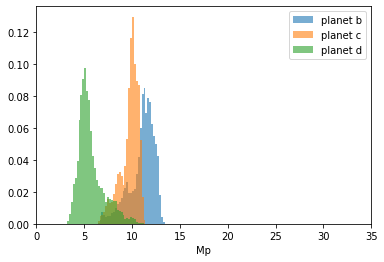

In [22]:
_=plt.hist(3.329e5*np.exp(stepresult['weighted_samples']['points'][:,1]+stepresult['weighted_samples']['points'][:,0]),
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,35,0.2),
           alpha=0.6,label='planet b')
_=plt.hist(3.329e5*np.exp(stepresult['weighted_samples']['points'][:,8]+stepresult['weighted_samples']['points'][:,1]+stepresult['weighted_samples']['points'][:,0]),
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,35,0.2),
           alpha=0.6,label='planet c')
_=plt.hist(3.329e5*np.exp(stepresult['weighted_samples']['points'][:,15]+stepresult['weighted_samples']['points'][:,1]+stepresult['weighted_samples']['points'][:,0]),
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,35,0.2),
           alpha=0.6,label='planet d')
plt.legend()
plt.xlim(0,35)
filename="reparameterised_eccomega_2dtrans_ultranest_analysis_3pl"
plt.xlabel('Mp')
plt.savefig(filename+"_masspdfs.png")

Text(0.5, 0, 'ecc')

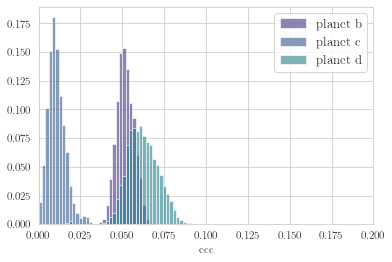

In [257]:
_=plt.hist(stepresult['weighted_samples']['points'][:,3],
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,0.2,0.002),
           alpha=0.6,label='planet b')
_=plt.hist(stepresult['weighted_samples']['points'][:,3+7],
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,0.2,0.002),
           alpha=0.6,label='planet c')
_=plt.hist(stepresult['weighted_samples']['points'][:,3+7*2],
           weights=stepresult['weighted_samples']['weights'],bins=np.arange(0,0.2,0.002),
           alpha=0.6,label='planet d')
plt.legend()
plt.xlim(0,0.2)
plt.xlabel('ecc')

Text(0.5, 0, 'incl')

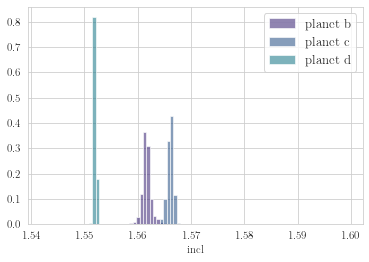

In [261]:
_=plt.hist(stepresult['weighted_samples']['points'][:,5],
           weights=stepresult['weighted_samples']['weights'],bins=np.linspace(0.98*np.pi/2,1.02*np.pi/2,100),
           alpha=0.6,label='planet b')
_=plt.hist(stepresult['weighted_samples']['points'][:,5+7],
           weights=stepresult['weighted_samples']['weights'],bins=np.linspace(0.98*np.pi/2,1.02*np.pi/2,100),
           alpha=0.6,label='planet c')
_=plt.hist(stepresult['weighted_samples']['points'][:,5+7*2],
           weights=stepresult['weighted_samples']['weights'],bins=np.linspace(0.98*np.pi/2,1.02*np.pi/2,100),
           alpha=0.6,label='planet d')
plt.legend()
plt.xlim(0.98*np.pi/2,1.02*np.pi/2)
plt.xlabel('incl')

Text(0.5, 0, 'argument')

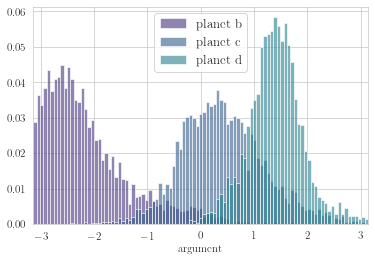

In [256]:
_=plt.hist(stepresult['weighted_samples']['points'][:,6],
           weights=stepresult['weighted_samples']['weights'],bins=np.linspace(-np.pi,np.pi,100),
           alpha=0.6,label='planet b')
_=plt.hist(stepresult['weighted_samples']['points'][:,6+7],
           weights=stepresult['weighted_samples']['weights'],bins=np.linspace(-np.pi,np.pi,100),
           alpha=0.6,label='planet c')
_=plt.hist(stepresult['weighted_samples']['points'][:,6+7*2],
           weights=stepresult['weighted_samples']['weights'],bins=np.linspace(-np.pi,np.pi,100),
           alpha=0.6,label='planet d')
plt.legend()
plt.xlim(-1*np.pi,np.pi)
plt.xlabel('argument')

In [ ]:
plot_params(stepresult['weighted_samples']['points'],savename=filename+"_models.pdf")


In [79]:
init_x=[]
for var in pars:
    if pars[var][0]=='norm':
        init_x+=[pars[var][1]]
    elif pars[var][0]=='uniform':
        init_x+=[0.5*(pars[var][1]+pars[var][2])]
    elif pars[var][0]=='beta':
        init_x+=[0.01]

In [ ]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)


In [ ]:
values=np.random.normal(1.0,0.1,20)[None,:]*np.sin(np.arange(0,7,0.1)[:,None]/np.random.normal(1.0,0.05,20)[None,:])
values=values.T
quantiles=[0.26,0.5,0.84]
sample_weight=np.random.random(20)
values_sorted=False
old_style=False
#def weighted_quantile_2d(values, quantiles, sample_weight=None, 
#                      values_sorted=False, old_style=False):
""" Very close to numpy.percentile, but supports weights.
NOTE: quantiles should be in [0, 1]!
:param values: numpy.array with data
:param quantiles: array-like with many quantiles needed
:param sample_weight: array-like of the same length as `array`
:param values_sorted: bool, if True, then will avoid sorting of
    initial array
:param old_style: if True, will correct output to be consistent
    with numpy.percentile.
:return: numpy.array with computed quantiles.
"""
values = np.array(values)
quantiles = np.array(quantiles)
if sample_weight is None:
    sample_weight = np.ones(values.shape)
else:
    assert len(sample_weight)==values.shape[0]
sample_weight = np.array(sample_weight)
assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
    'quantiles should be in [0, 1]'
'''
if not values_sorted:
    sorter = np.argsort(values,axis=0)
    newvalues=values[sorter,np.tile(np.arange(values.shape[0]),(values.shape[1],1)).T,]
    sorted_weight = sample_weight[sorter]
weighted_quantiles = np.cumsum(sorted_weight,axis=0) - 0.5 * sorted_weight
if old_style:
    # To be convenient with numpy.percentile
    weighted_quantiles -= weighted_quantiles[0]
    weighted_quantiles /= weighted_quantiles[-1]
else:
    weighted_quantiles /= np.sum(sorted_weight)'''
out_quantiles=interp.interp1d(sample_weight,values,axis=1)(quantiles)

In [59]:
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('viridis')

from matplotlib import rc
rc('text', usetex=True)
rc('font', size=14)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 


<ipython-input-59-d538185ca5b9>:12: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


In [129]:
priortypes={'beta':' $\\beta(a=q1;b=q2)^{\\tnote{a}}$',
            'truncnorm':' $\\mathcal{N}_{\\mathcal{U}}(a=q3,b=q4,\\mu=q1,\\sigma=q2)$',
            'xo.distributions.Angle':' $\\mathcal{U}(-\\pi,\\pi)^{\\tnote{b}}$',
            'uniform':' $\\mathcal{U}(a=q1,b=q2)$',
            'xo.distributions.ImpactParameter':'$\\mathcal{U}(a=0,b=1+R_p/R_s)^{\\tnote{c}}$',
            'norm':' $\\mathcal{N}(\\mu=q1,\\sigma=q2)$',
            'halfnorm':' $|\\mathcal{N}(q1,q2)|$',
            'xo.UnitUniform':' $\\mathcal{U}(a=0,b=1)$',
            'xo.distributions.UnitUniform':' $\\mathcal{U}(a=0,b=1)$',
            'pm.Interpolated':'$\\mathcal{I}{q1,q2}^{\\tnote{d}}$'}
names={'Ms':'Solar Mass $ M_s $ [$M_\odot$]', 'logjitter':'Log jitter, $\\log{{\\sigma_{{s}}/{{\\rm ppt}}}}$'}
for n,q in enumerate('bcd'):
    if n==0:
        names.update({'logMpbMs':'log mass ratio, $ \log{M_{p,'+q+'} / M_{s}} $',
                      'P_'+q:'Period, $P_'+q+'$ [d]'})
    else:
        names.update({'logMp'+q+'/Mb':'log mass ratio, $ \log{M_{p,'+q+'} / M_{p, b}} $',
                      'P'+q+'/Pb':'Period ratio, $P_'+q+'/P_b$'})

    names.update({'ecc_'+q:'$ e_{'+q+'} $', 
                  'omega_'+q:'$ \omega_{'+q+'} $', 
                  'incl_'+q:'Inclination, $ i_{'+q+'} $ [$^{\circ}$]',
                  'longnode_'+q:'Longitude of Ascending Node, $ \Omega_{'+q+'} $ [$^{\circ}$]',
                  'epoch'+q:'Transit Epoch, $ t_{0, '+q+'} $ [BJD-2457000]'})

def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)


def vals_to_latex(vals):
    #Function to turn -1,0, and +1 sigma values into round latex strings for a table
    try:
        roundval=int(np.min([-1*np.floor(np.log10(abs(vals[1]-vals[0])))+1,-1*np.floor(np.log10(abs(vals[2]-vals[1])))+1]))
        errs=[vals[2]-vals[1],vals[1]-vals[0]]
        if np.round(errs[0],roundval-1)==np.round(errs[1],roundval-1):
            #Errors effectively the same...
            if roundval<0:
                return " $ "+str(int(np.round(vals[1],roundval)))+" \pm "+str(int(np.round(np.average(errs),roundval)))+" $ "
            else:
                return " $ "+str(np.round(vals[1],roundval))+" \pm "+str(np.round(np.average(errs),roundval))+" $ "
        else:
            if roundval<0:
                return " $ "+str(int(np.round(vals[1],roundval)))+"^{+"+str(int(np.round(errs[0],roundval)))+"}_{-"+str(int(np.round(errs[1],roundval)))+"} $ "
            else:
                return " $ "+str(np.round(vals[1],roundval))+"^{+"+str(np.round(errs[0],roundval))+"}_{-"+str(np.round(errs[1],roundval))+"} $ "
    except:
        return " - "

def vals_to_short(vals,roundval=None):
    #Function to turn -1,0, and +1 sigma values into round latex strings for a table
    try:
        if roundval is None:
            roundval=int(np.min([-1*np.floor(np.log10(abs(vals[1]-vals[0])))+1,-1*np.floor(np.log10(abs(vals[2]-vals[1])))+1]))-1
        return " $ "+str(np.round(vals[1],roundval))+" $ "
    except:
        return " - "
    
def vals_to_overleaf(name,vals,include_short=True):
    if len(vals)==2 and vals[1]<0.5*vals[0]:
        vals=[vals[0]-vals[1],vals[0],vals[0]+vals[1]]
    
    replace_vals = {'_':'','[':'',']':'','-':'minus','1':'one','2':'two','3':'three','4':'four','5':'five','6':'six','7':'seven','8':'eight','9':'nine','/':'div'}
    for symbol, text in replace_vals.items():
        name = name.replace(symbol, text)
    st = "\\newcommand{\\T"+name+"}{"+vals_to_latex(vals)+"}\n"
    if include_short:
        st+="\\newcommand{\\T"+name+"short}{"+vals_to_short(vals)+"}\n"
    return st



In [130]:

strings=[]
allnames=[]
modeltab=[]
for ni,name in enumerate(pars):
    commandname='ttv'+name if name=='Ms' else name
    quants=weighted_quantile(data[ix,2+ni], np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
    strings+=[vals_to_overleaf(commandname,quants)]
    allnames+=[name]
    if pars[name][0]=='beta' or pars[name][0] =='uniform' or pars[name][0] =='halfnorm':
        modeltab+=[names[name]+" & "+priortypes[pars[name][0]].replace('q1',str.format('{0:.3g}', pars[name][1])).replace('q2',str.format('{0:.3g}', pars[name][2]))+" & "+vals_to_latex(quants)+" \\\\"]
    elif pars[name][0]=='norm':
        roundval=int(-1*np.floor(np.log10(pars[name][2]))+1)
        print(name,roundval,np.round(pars[name][1],roundval),np.round(pars[name][2],roundval))
        modeltab+=[names[name]+" & "+priortypes[pars[name][0]].replace('q1',str(np.round(pars[name][1],roundval))).replace('q2',str(np.round(pars[name][2],roundval)))+" & "+vals_to_latex(quants)+" \\\\"]
    elif pars[name][0]=='truncnorm':
        roundval=int(-1*np.floor(np.log10(pars[name][2]))+1)
        print(name,roundval,np.round(pars[name][1],roundval),np.round(pars[name][2],roundval))
        modeltab+=[names[name]+" & "+priortypes[pars[name][0]].replace('q1',str(np.round(pars[name][1],roundval))).replace('q2',str(np.round(pars[name][2],roundval))).replace('q3',str(np.round(pars[name][3],roundval))).replace('q4',str(np.round(pars[name][4],roundval)))+" & "+vals_to_latex(quants)+" \\\\"]

for ni,name in enumerate(pars):
    if 'log' in name and name not in allnames:
        strings+=[vals_to_overleaf(name.replace('log',''),[np.exp(q) for q in quants])]
        allnames+=[name.replace('log','')]
    allnames+=[name]
    
    
Mb=np.exp(data[ix,3])*data[ix,2]*3.329e5
quants=weighted_quantile(Mb, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvMb',quants)]

Mc=data[ix,2]*3.329e5*np.exp(data[ix,3]+data[ix,10])
quants=weighted_quantile(Mc, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvMc',quants)]

Md=data[ix,2]*3.329e5*np.exp(data[ix,3]+data[ix,17])
quants=weighted_quantile(Md, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvMd',quants)]

perb=data[ix,4]
quants=weighted_quantile(perb, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvperb',quants)]

perc=data[ix,4]*data[ix,11]
quants=weighted_quantile(perc, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvperc',quants)]

perd=data[ix,4]*data[ix,18]
quants=weighted_quantile(perd, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvperd',quants)]

Kb = Mb / (((2*np.pi*6.67e-11)/(86400*perb))**(-1/3)/np.sqrt(1-np.tan(data[ix,7])**-2)**(-0.5) * (1-data[ix,5]**2)**0.5*(1.9884e30*data[ix,2])**(2/3)/5.972e24)
quants=weighted_quantile(Kb, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvKb',quants)]
Kc = Mc / (((2*np.pi*6.67e-11)/(86400*perc))**(-1/3)/np.sqrt(1-np.tan(data[ix,14])**-2)**(-0.5) * (1-data[ix,12]**2)**0.5*(1.9884e30*data[ix,2])**(2/3)/5.972e24)
quants=weighted_quantile(Kc, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvKc',quants)]
Kd = Md / (((2*np.pi*6.67e-11)/(86400*perd))**(-1/3)/np.sqrt(1-np.tan(data[ix,21])**-2)**(-0.5) * (1-data[ix,19]**2)**0.5*(1.9884e30*data[ix,2])**(2/3)/5.972e24)
quants=weighted_quantile(Kd, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0])
strings+=[vals_to_overleaf('ttvKd',quants)]

traceix=np.random.choice(len(trace['Rs']),Mb.shape[0],replace=False)
TSMwmb=trace['TSM'][traceix,0]*trace['Mp_est'][traceix,0]/Mb
strings+=[vals_to_overleaf('ttvTSMb',weighted_quantile(TSMwmb, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0]))]
traceix=np.random.choice(len(trace['Rs']),Mb.shape[0],replace=False)
TSMwmc=trace['TSM'][traceix,1]*trace['Mp_est'][traceix,1]/Mc
strings+=[vals_to_overleaf('ttvTSMc',weighted_quantile(TSMwmc, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0]))]
traceix=np.random.choice(len(trace['Rs']),Mb.shape[0],replace=False)
TSMwmd=trace['TSM'][traceix,2]*trace['Mp_est'][traceix,2]/Md
strings+=[vals_to_overleaf('ttvTSMd',weighted_quantile(TSMwmd, np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0]))]

from scipy.special import logsumexp
#Creating MCMC trace weights
rand_trace_choices=np.random.choice(trace['r_pl'].shape[0],len(drvdat.loc[drvdat['planet']=='b','Mass, $M_p$ [$M_\oplus$]']))
#Renormalising the multiplied weights such that they sum to zero
rho_earth=5.514

strings+=[vals_to_overleaf('ttvrhob',weighted_quantile(rho_earth*drvdat.loc[drvdat['planet']=='b','Mass, $M_p$ [$M_\oplus$]']/trace['r_pl'][rand_trace_choices,0]**3, 
                                                     np.array([15.87,50,84.13])*0.01,sample_weight=drvdat.loc[drvdat['planet']=='b','weight']))]
strings+=[vals_to_overleaf('ttvrhoc',weighted_quantile(rho_earth*drvdat.loc[drvdat['planet']=='c','Mass, $M_p$ [$M_\oplus$]']/trace['r_pl'][rand_trace_choices,1]**3, 
                                                     np.array([15.87,50,84.13])*0.01,sample_weight=drvdat.loc[drvdat['planet']=='c','weight']))]
strings+=[vals_to_overleaf('ttvrhod',weighted_quantile(rho_earth*drvdat.loc[drvdat['planet']=='d','Mass, $M_p$ [$M_\oplus$]']/trace['r_pl'][rand_trace_choices,2]**3, 
                                                     np.array([15.87,50,84.13])*0.01,sample_weight=drvdat.loc[drvdat['planet']=='d','weight']))]
strings+=[vals_to_overleaf('ttvbcsuperper',weighted_quantile(1/abs(2/(data[ix,4]*data[ix,11]) - (2-1)/data[ix,4]), 
                                                     np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0]))]
strings+=[vals_to_overleaf('ttvcdsuperper',weighted_quantile(1/abs(5/(data[ix,4]*data[ix,18]) - 3/(data[ix,4]*data[ix,11])), 
                                                     np.array([15.87,50,84.13])*0.01,sample_weight=data[ix,0]))]


from datetime import datetime
with open("TOI-2076CheopsPaper/TTVFileOutput"+datetime.now().strftime("%Y%m%d%H")+".tex","wb") as filez:
    for line in strings:
        filez.write((line+"\n").encode())

with open("TOI-2076CheopsPaper/TTVModelPriorTab"+datetime.now().strftime("%Y%m%d%H")+".tex","wb") as filez2:
    for line in modeltab:
        filez2.write((line+"\n").encode())

Ms 3 0.865 0.036
logMpbMs 2 -10.52 0.58
P_b 4 10.355 0.0013
incl_b 3 1.563 0.011
epochb 3 1743.728 0.05
logMpc/Mb 2 0.38 0.62
Pc/Pb 3 2.03 0.013
incl_c 4 1.5673 0.0061
epochc 3 1748.689 0.05
logMpd/Mb 2 0.27 0.62
Pd/Pb 4 3.3921 0.0044
incl_d 5 1.55166 0.00099
epochd 3 1762.667 0.05


In [128]:
"TTVFileOutput"+datetime.now().strftime("%Y%m%d%H")+".tex"

'TTVFileOutput2021112621.tex'

In [124]:
strings

['\\newcommand{\\TttvMs}{ $ 0.882^{+0.028}_{-0.051} $ }\n\\newcommand{\\TttvMsshort}{ $ 0.88 $ }\n',
 '\\newcommand{\\TlogMpbMs}{ $ -10.82^{+0.39}_{-0.6} $ }\n\\newcommand{\\TlogMpbMsshort}{ $ -10.8 $ }\n',
 '\\newcommand{\\TPb}{ $ 10.35509^{+0.0002}_{-0.00014} $ }\n\\newcommand{\\TPbshort}{ $ 10.3551 $ }\n',
 '\\newcommand{\\Teccb}{ $ 0.023 \\pm 0.02 $ }\n\\newcommand{\\Teccbshort}{ $ 0.02 $ }\n',
 '\\newcommand{\\Tomegab}{ $ -0.6 \\pm 1.7 $ }\n\\newcommand{\\Tomegabshort}{ $ -1.0 $ }\n',
 '\\newcommand{\\Tinclb}{ $ 1.567 \\pm 0.013 $ }\n\\newcommand{\\Tinclbshort}{ $ 1.57 $ }\n',
 '\\newcommand{\\Tlongnodeb}{ $ 0.2 \\pm 1.9 $ }\n\\newcommand{\\Tlongnodebshort}{ $ 0.0 $ }\n',
 '\\newcommand{\\Tepochb}{ $ 1743.7231^{+0.0061}_{-0.0087} $ }\n\\newcommand{\\Tepochbshort}{ $ 1743.723 $ }\n',
 '\\newcommand{\\TlogMpcdivMb}{ $ 0.1 \\pm 0.2 $ }\n\\newcommand{\\TlogMpcdivMbshort}{ $ 0.1 $ }\n',
 '\\newcommand{\\TPcdivPb}{ $ 2.02947 \\pm 0.00011 $ }\n\\newcommand{\\TPcdivPbshort}{ $ 2.0295 $ }\

In [1]:
1/abs(5/(141.32) - 3/83.263)

1539.1402432962814

In [256]:
#2*np.pi/abs(5*n_2 - 3*n_1)
#
1/abs(2/(data[ix,4]*data[ix,11]) - (2-1)/data[ix,4]),1/abs(5/(data[ix,4]*data[ix,18]) - 3/(data[ix,4]*data[ix,11]))


(array([709.94313553, 709.89998779, 709.32078417, ..., 709.03580091,
        709.15263591, 709.14222819]),
 array([2489.74156293, 2486.64226957, 2519.87774276, ..., 2516.43403463,
        2506.40857272, 2515.32742133]))

In [239]:
drvdat.loc[drvdat['planet']=='b','Mass, $M_p$ [$M_\oplus$]']/trace['r_pl'][,0]**3

(14068,)

1.0000000000001799

In [230]:
drvdat.columns

Index(['Mass, $M_p$ [$M_\oplus$]', 'Eccentricity, $e$', 'planet', 'weight'], dtype='object')

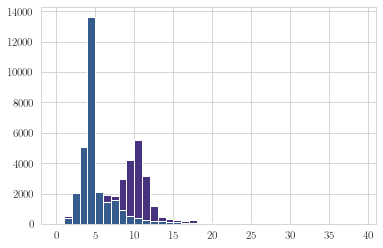

In [74]:
_=plt.hist(fixsampler.pointpile.ps[:len(stepresult['weighted_samples']['weights']),0]*3.329e5*np.exp(fixsampler.pointpile.ps[:len(stepresult['weighted_samples']['weights']),1]+fixsampler.pointpile.ps[:len(stepresult['weighted_samples']['weights']),15]),bins=np.arange(0,40,1))
_=plt.hist(fixsampler.pointpile.ps[:len(stepresult['weighted_samples']['weights']),0]*3.329e5*np.exp(fixsampler.pointpile.ps[:len(stepresult['weighted_samples']['weights']),1]+fixsampler.pointpile.ps[:len(stepresult['weighted_samples']['weights']),8]),bins=np.arange(0,40,1))


In [90]:
from datetime import datetime
derivetab=[]


with open("TOI-2076CheopsPaper/TTVModelDerivedTab"+datetime.now().strftime("%Y%m%d%H")+".tex","wb") as filez3:
    for line in derivetab:
        filez3.write((line+"\n").encode())


In [92]:
"TOI-2076CheopsPaper/TTVModelDerivedTab"+datetime.now().strftime("%Y%m%d%H")

'TOI-2076CheopsPaper/TTVModelDerivedTab2021112615'

## quants

In [54]:
pars.keys()

dict_keys(['Ms', 'logMp_b', 'P_b', 'ecc_b', 'incl_b', 'longnode_b', 'argument_b', 'epochb', 'logMp_c', 'P_c', 'ecc_c', 'incl_c', 'longnode_c', 'argument_c', 'epochc', 'logMp_d', 'P_d', 'ecc_d', 'incl_d', 'longnode_d', 'argument_d', 'epochd'])

In [36]:
fixsampler.pointpile.ps[:,ni].shape

(154000,)

In [38]:
stepresult['weighted_samples']['weights'].shape

(152696,)

In [32]:
weighted_quantile?

In [ ]:
#Z=-1e+09(0.00%) | Like=-1.5e+09..-7e+08 [-1.475e+09..-1.38e+09] | it/evals=10692/2993122 eff=0.4277% N=400  0 
#Z=-7e+08(0.00%) | Like=-6.6e+08..-4.9e+08 [-6.939e+08..-6.501e+08] | it/evals=13659/3801263 eff=0.4055% N=400
#Z=-5e+08(0.00%) | Like=-4.9e+08..-4.6e+08 [-4.905e+08..-4.835e+08] | it/evals=16053/4543007 eff=0.3846% N=400 
#Z=-5e+08(0.00%) | Like=-4.6e+08..-4.5e+08 [-4.606e+08..-4.593e+08] | it/evals=19241/5529312 eff=0.3692% N=400
#Z=-5e+08(0.00%) | Like=-4.5e+08..-4.5e+08 [-4.538e+08..-4.532e+08] | it/evals=21004/6007977 eff=0.3691% N=400 
#Z=-4e+08(0.00%) | Like=-4.5e+08..-4.5e+08 [-4.495e+08..-4.492e+08] | it/evals=23771/7064486 eff=3.6102% N=400    
#Z=-4e+08(0.00%) | Like=-4.5e+08..-4.5e+08 [-4.48e+08..-4.478e+08] | it/evals=25399/7954008 eff=1.6408% N=400     
#Z=-4e+08(0.00%) | Like=-4.5e+08..-4.5e+08 [-4.473e+08..-4.472e+08] | it/evals=26694/8804248 eff=1.1131% N=400    
#Z=-4e+08(0.00%) | Like=-4.5e+08..-4.5e+08 [-4.467e+08..-4.466e+08] | it/evals=27939/9766782 eff=0.8313% N=400
#Z=-4e+08(0.00%) | Like=-4.5e+08..-4.5e+08 [-4.462e+08..-4.462e+08] | it/evals=29429/11084017 eff=0.6291% N=400 
#Z=-4e+08(0.00%) | Like=-4.5e+08..-4.5e+08 [-4.456e+08..-4.456e+08] | it/evals=31886/13703932 eff=0.4369% N=400
#Z=-4e+08(0.00%) | Like=-4.4e+08..-4.4e+08 [-4.443e+08..-4.443e+08] | it/evals=52570/33627492 eff=0.1931% N=400
#Z=-4e+08(0.00%) | Like=-4.4e+08..-4.4e+08 [-4.443e+08..-4.443e+08] | it/evals=53332/34875098 eff=0.1873% N=400   
#Z=-4e+08(0.00%) | Like=-4.4e+08..-4.4e+08 [-4.443e+08..-4.443e+08] | it/evals=53729/35551068 eff=0.1844% N=400
#Z=-4e+08(0.00%) | Like=-4.4e+08..-4.4e+08 [-4.443e+08..-4.443e+08] | it/evals=56152/40040336 eff=0.1669% N=400

In [ ]:
#4677/1499718 eff=0.3119
#4689/1533180 eff=0.3059
#4718/1578117 eff=0.2990%